In [1]:
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,RobustScaler,\
                                    OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#model improvement
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.inspection import permutation_importance

#evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error,\
                            r2_score,mean_absolute_percentage_error

#storing and loading 
import joblib
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/insurance/insurance.csv


In [3]:
df= pd.read_csv('/kaggle/input/insurance/insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
print(f'Shape of the data: {df.shape}')
print(f'There are {df.shape[0]} rows in the data.\n')

df.info()

Shape of the data: (1338, 7)
There are 1338 rows in the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# select columns of object data type 
categorical_cols= list(df.select_dtypes(include='object'))
categorical_cols

['sex', 'smoker', 'region']

In [7]:
# select columns of numeric data type 
numerical_cols= list(df.select_dtypes(include='number'))
numerical_cols

['age', 'bmi', 'children', 'charges']

In [8]:
print('the total number of duplicated rows:',
      df.duplicated().sum())

the total number of duplicated rows: 1


In [9]:
# identify and retrieve rows that are duplicates
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [10]:
# remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)

print('the total number of duplicated rows:',
      df.duplicated().sum())

the total number of duplicated rows: 0


In [11]:
# Calculate the total missing value in each column
missing_values = df.isnull().sum()

# Calculate the percentage of missing values in each column
percentage_missing_values = (missing_values / len(df)) * 100

# Create a new dataframe to store the total and percentage of missing values
missing_df = pd.DataFrame(
    {'Total Missing Values': missing_values, 
     'Percentage': percentage_missing_values})

missing_df

,Total Missing Values,Percentage
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


In [12]:
# summary statistics of categorical columns
df[categorical_cols].describe()

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


In [13]:
# Loop through the categorical columns and print unique values in each column
for col in categorical_cols:
  print(f'unique values in a column {col}:\
  \n{df[col].unique()}\n')

unique values in a column sex:  
['female' 'male']

unique values in a column smoker:  
['yes' 'no']

unique values in a column region:  
['southwest' 'southeast' 'northwest' 'northeast']



In [14]:
# Create a function to calculate value counts for a specified variable
def val_counts(df, var):
    results = df[var].value_counts(sort=False)
    labels = results.index
    counts = results.values
    return labels, counts

labels = val_counts(df, 'sex')[0]
values= val_counts(df, 'sex')[1]
colors = ['#bb2b77','#95cbee']
explode = (0.05, 0) # Explode the first slice for emphasis 

def visualize_piechart(labels=None, values= None, 
                       explode=None, colors=colors,var=None):
    
    ## Create a Pie chart
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, 
                                 pull=explode, 
                                 marker=dict(
                                     colors=colors,
                                     line=dict(color='#000000', width=2)))])

    # Adjusting the position of the horizontal legend
    fig.update_layout(
        legend=dict(
            x=0.5, y=1.15, 
            xanchor='center',
            orientation='h',  # Horizontal orientation
            bgcolor='rgba(211,211,211,0.3)',  # legend background
            font=dict(size=12)    
        ),
        title=dict(text=f'{var} Distribution', x=0.5, y=0.95) 
    )
    
    return fig.show()

In [15]:
visualize_piechart(labels=labels, values= values,explode=explode,var='Gender')

In [16]:
smoker_labels = val_counts(df, 'smoker')[0]
smoker_values= val_counts(df, 'smoker')[1]

visualize_piechart(labels=smoker_labels, values= smoker_values,
                   explode=explode,var='Smoker')

In [17]:
# Querying the DataFrame to separate data for non-smokers and smokers
query_smoker_no= df.query('smoker=="no"')
query_smoker_yes= df.query('smoker=="yes"')

labels_no = val_counts(query_smoker_no, 'sex')[0]
values_no= val_counts(query_smoker_no, 'sex')[1]
labels_yes = val_counts(query_smoker_yes, 'sex')[0]
values_yes= val_counts(query_smoker_yes, 'sex')[1]


# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels_no, values=values_no, 
                     marker=dict(colors=colors)
                    ),
              row=1, col=1)
fig.add_trace(go.Pie(labels=labels_yes, values=values_yes, 
                     marker=dict(colors=colors)
                    ),
              row=1, col=2)

# Use `hole` to create a donut-like pie chart
# Use `hoverinfo` to define what information is displayed 
# when the user hovers the cursor over data points
fig.update_traces(hole=.4, hoverinfo="label+value+percent+name")

fig.update_layout(
    title_text="Distribution of Smoker by Gender",

    # Add annotations in the center of the donut pies.
    annotations=[dict(text='No', x=0.20, y=0.5, font_size=20, showarrow=False),
                 dict(text='Yes', x=0.81, y=0.5, font_size=20, showarrow=False)],
    
    # Adjusting the position of legend
    legend=dict(x=0.5, y=1.1, xanchor='center',
        orientation='h',  # Horizontal orientation
        bgcolor='rgba(211,211,211,0.3)',  # legend background color
        font=dict(size=12))
)
fig.show()

In [88]:
# Count the number of smokers in each region
labels_no = val_counts(query_smoker_no, 'region')[0]
values_no= val_counts(query_smoker_no, 'region')[1]
labels_yes = val_counts(query_smoker_yes, 'region')[0]
values_yes= val_counts(query_smoker_yes, 'region')[1]

colors= ['#A721F4','#F22E8B','#95cbee','#6A2EF2']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=labels_no, values=values_no, marker=dict(colors=colors)),
              row=1, col=1)
fig.add_trace(go.Pie(labels=labels_yes, values=values_yes, marker=dict(colors=colors)),
              row=1, col=2)

fig.update_traces(hole=.4, hoverinfo="label+value+percent+name")

fig.update_layout(
    title_text="Distribution of Smoker by Region",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='No', x=0.20, y=0.5, font_size=20, showarrow=False),
                 dict(text='Yes', x=0.80, y=0.5, font_size=20, showarrow=False)],
    
    # Adjusting the position of legend
    legend=dict(x=0.5, y=1.1, xanchor='center',
        orientation='h',  # Horizontal orientation
        bgcolor='rgba(211,211,211,0.3)',  # legend background
        font=dict(size=12))
)
fig.show()

In [19]:
# summary statistics of numerical columns
df[numerical_cols].describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [20]:
df['children'].value_counts()

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

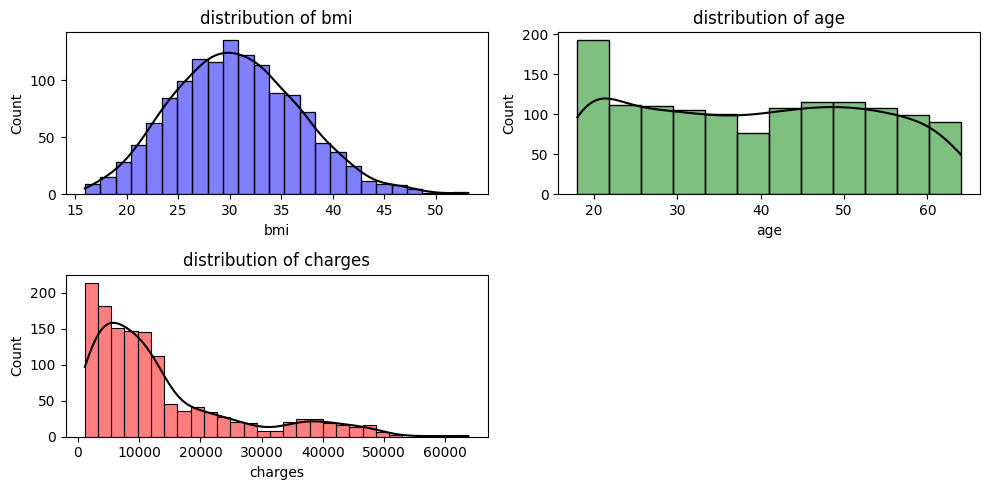

In [21]:
# Creating a subplot with 1 row and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# Looping through each variable
var_dict={'bmi':'blue','age':'green','charges': 'red'}
row_col = [(0, 0), (0, 1), (1, 0)]  # (row, col)
for i,(var,color) in enumerate(var_dict.items()):
    row, col= row_col[i]
    #row = (i // 2) + 1
    #col = (i % 2) + 1
    sns.histplot(data=df, x=var, kde=True, ax=axes[row, col], color=color)
    axes[row, col].set_title(f'distribution of {var}')
    axes[row, col].lines[0].set_color('black')

# Remove the unused subplot
fig.delaxes(axes[1, 1])

# Adjusting plot layout
plt.tight_layout()

# Displaying the plot
plt.show()

In [22]:
# Calculating skewness and kurtosis
skewness_kurtosis = df[['bmi', 'age', 'charges']].agg(['skew', 'kurt'])
skewness_kurtosis.T

,skew,kurt
bmi,0.283914,-0.052947
age,0.054781,-1.244406
charges,1.515391,1.604221


In [23]:
def check_outliers(var):
    # Calculating total outliers
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    total_outliers = len(df[(df[var] < lower_bound) | (df[var] > upper_bound)])
    return total_outliers, lower_bound, upper_bound

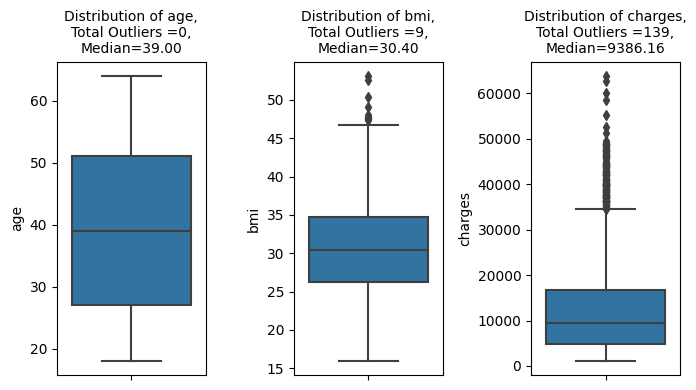

In [24]:
# Creating a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(7, 4))


# Looping through each variable
for i, var in enumerate(['age','bmi','charges']):
    sns.boxplot(data=df, y=var, ax=axes[i],)
    title= f'Distribution of {var},\nTotal Outliers ={check_outliers(var)[0]},\nMedian={df[var].median():.2f}'
    
    axes[i].set_title(title,fontsize=10)


# Adjusting plot layout
plt.tight_layout()

# Displaying the plot
plt.show()

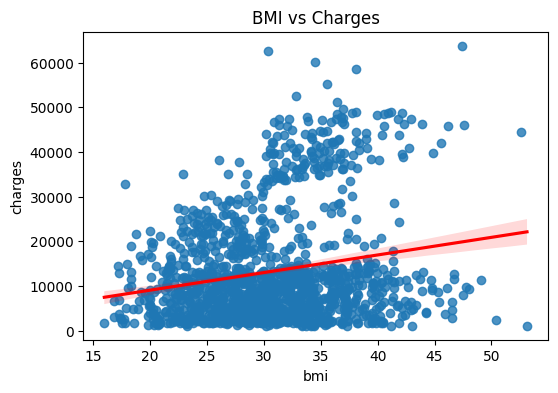

In [25]:
# Plotting BMI vs Charges scatter plot
plt.figure(figsize=(6,4))
sns.regplot(data=df, x='bmi', y='charges', line_kws={"color": "red"})
plt.title('BMI vs Charges');

In [26]:
color = {'yes': '#DC143C', 'no': '#1E90FF'}
fig = px.scatter(df, x="bmi", y="charges", trendline="ols", 
                 color='smoker', color_discrete_map=color)

fig.update_layout(
    height=500,  
    width=600,
    title= 'Relationship between BMI, Charges, and Smoking Status'
)
fig.show()

In [27]:
fig = px.scatter(df, x="age", y="charges", trendline="ols", 
                 color='smoker',color_discrete_map=color)

fig.update_layout(
    height=500,  
    width=600,
    title= 'Relationship between Age, Charges, and Smoking Status'
)
fig.show()

In [28]:
# Because children are discrete numbers from 0-5, We use box plots to make it easier to see patterns from the data.
fig = px.box(df, x="children", y="charges", color="smoker",
            color_discrete_map=color)
fig.show()


In [29]:
fig = px.box(df, x="sex", y="charges",color='smoker',
            color_discrete_map=color)
fig.show()


In [30]:
df.query("smoker=='yes'").groupby(['sex'])['charges'].median().sort_values()

sex
female    28950.4692
male      36085.2190
Name: charges, dtype: float64

In [31]:
fig = px.box(df, x="region", y="charges",
            color_discrete_map=color)
fig.show()


In [32]:
df.groupby(['region'])['charges'].median().sort_values()

region
southwest     8798.593000
northwest     8976.977250
southeast     9294.131950
northeast    10057.652025
Name: charges, dtype: float64

In [33]:
smokers = df.query("smoker=='yes'")
non_smokers = df.query("smoker=='no'")
charge_smokers = smokers['charges']
charge_non_smokers = non_smokers['charges']

print(f'Variance in charges of smokers: {np.var(charge_smokers):.2f}')
print(f'Variance in charges of non-smokers: {np.var(charge_non_smokers):.2f}')
print(f'mean in charges of smokers: {np.mean(charge_smokers):.2f}')
print(f'mean in charges of non-smokers: {np.mean(charge_non_smokers):.2f}')

Variance in charges of smokers: 132721153.14
Variance in charges of non-smokers: 35881947.82
mean in charges of smokers: 32050.23
mean in charges of non-smokers: 8440.66


In [34]:
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(charge_smokers, charge_non_smokers, equal_var=False)
print(f't_statistic: {t_statistic}\np_value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha and make a conclusion
if p_value < alpha:
    print("Reject the null hypothesis: mean charges for smokers and non-smokers are different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in mean charges between smokers and non-smokers.")

t_statistic: 32.7423097372529
p_value: 6.261720774727631e-103
Reject the null hypothesis: mean charges for smokers and non-smokers are different.


In [35]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(charge_smokers, charge_non_smokers, alternative='two-sided')

print(f'Mann-Whitney U statistic: {statistic}')
print(f'p_value: {p_value}')

# Compare p-value with alpha and make a conclusion
if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences in health insurance costs between smokers and non-smokers.")
else:
    print("Fail to reject the null hypothesis: No significant difference between smokers and non-smokers.")


Mann-Whitney U statistic: 283859.0
p_value: 5.74701188239214e-130
Reject the null hypothesis: There are significant differences in health insurance costs between smokers and non-smokers.


In [36]:
df_new= df.copy()
df_new['smoker'] = df_new['smoker'].map({'no': 0, 'yes': 1})
df_new['sex'] = df_new['sex'].replace(['male','female'], [1,0])

# Perform one-hot encoding on the "region" column
df_encoded = pd.get_dummies(df_new, columns=['region'], dtype=float)

In [37]:
df_encoded.sample(5)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
542,63,0,36.300,0,0,13887.20400,0.0,0.0,1.0,0.0
431,29,0,20.235,2,0,4906.40965,0.0,1.0,0.0,0.0
215,41,0,37.100,2,0,7371.77200,0.0,0.0,0.0,1.0
233,59,1,27.500,1,0,12333.82800,0.0,0.0,0.0,1.0
1274,26,1,27.060,0,1,17043.34140,0.0,0.0,1.0,0.0


In [38]:
def viz_heatmap(data=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=".2f", 
                cmap = 'bwr', 
                mask=np.triu(data)); #only display the upper triangle of the correlation matrix

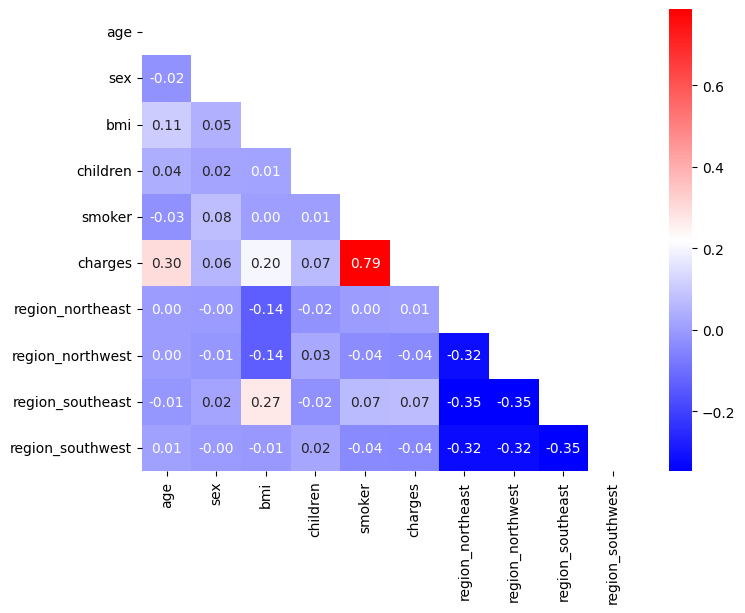

In [39]:
corr_1 = df_encoded.corr(method='pearson')
viz_heatmap(data=corr_1)

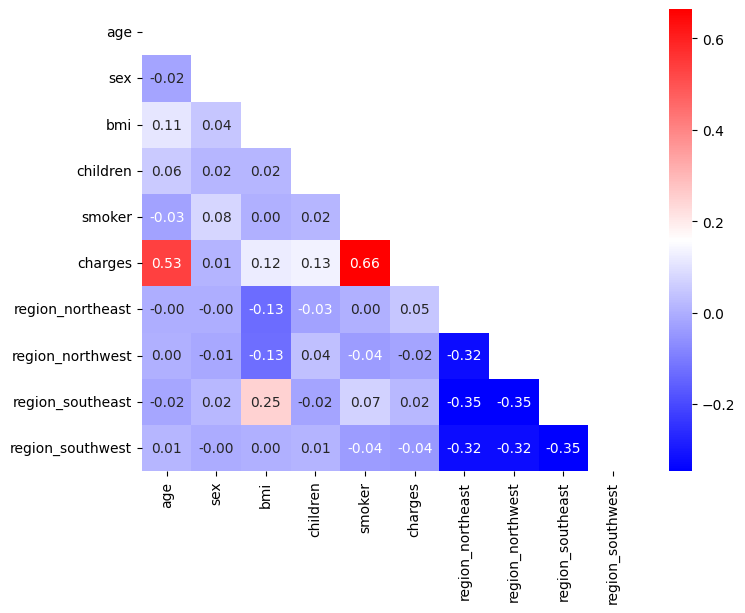

In [40]:
corr_2 = df_encoded.corr(method='spearman')
viz_heatmap(data=corr_2)

In [41]:
X= df.drop('charges',axis=1)
y= df['charges']

In [42]:
X['region'].value_counts(normalize=True).round(2)

region
southeast    0.27
southwest    0.24
northwest    0.24
northeast    0.24
Name: proportion, dtype: float64

In [43]:
X_train,X_test,y_train, y_test= train_test_split(X,y,test_size=0.2,
                                                random_state=42,
                                                stratify=X[['smoker','sex','region']]
                                               )

In [44]:
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (1069, 6)
X_test shape: (268, 6)


In [45]:
X_train['region'].value_counts(normalize=True).round(2)

region
southeast    0.27
southwest    0.24
northwest    0.24
northeast    0.24
Name: proportion, dtype: float64

In [46]:
X_train.head()

,age,sex,bmi,children,smoker,region
294,25,male,26.80,3,no,southwest
472,19,female,29.80,0,no,southwest
858,25,female,32.23,1,no,southeast
334,43,female,35.72,2,no,northeast
823,44,female,29.81,2,no,southeast


In [47]:
numerical_feature= ['bmi', 'children','age']
categorical_nominal= ['region']

categorical_biner = ['sex','smoker']
sex_values = ['female','male']
smoker_values = ['no','yes']

enc_1 = OrdinalEncoder(categories=[sex_values, smoker_values],
                     dtype='int8')

enc_2 = OneHotEncoder(sparse=False,dtype='int8')


numerical_pipeline= Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler())
])

categorical_biner_pipeline= Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding_ohe', enc_1),
])

categorical_nominal_pipepline= Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding_ohe', enc_2),
])

In [48]:
preproc_pipeline= ColumnTransformer(
    [
        ('num_pipeline',numerical_pipeline, numerical_feature),
        ('encoder_biner',categorical_biner_pipeline, categorical_biner),
        ('encoder_nominal',categorical_nominal_pipepline, categorical_nominal)
    ],
    remainder='passthrough',
    verbose=True
)


In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

class DtypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, dtype=np.float64):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(self.dtype)

    
convert_pipeline = Pipeline([
    ('preprocessor', preproc_pipeline),
    ('dtype_converter', DtypeConverter(dtype=np.float32))  # Convert to float32
])

In [50]:
X_train_new= convert_pipeline.fit_transform(X_train)
X_test_new= convert_pipeline.transform(X_test)

[ColumnTransformer] .. (1 of 3) Processing num_pipeline, total=   0.0s
[ColumnTransformer] . (2 of 3) Processing encoder_biner, total=   0.0s
[ColumnTransformer]  (3 of 3) Processing encoder_nominal, total=   0.0s


In [51]:
X_train_new.dtype

dtype('float32')

In [52]:
# Getting a list of column names after encoding
encoded_columns = preproc_pipeline.named_transformers_['encoder_nominal'].\
                  get_feature_names_out(categorical_nominal)

columns= (list(numerical_feature) + list(categorical_biner) + list(encoded_columns))


X_train_new = pd.DataFrame(X_train_new,columns=columns)
X_test_new = pd.DataFrame(X_test_new,columns=columns)

In [53]:
X_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bmi               1069 non-null   float32
 1   children          1069 non-null   float32
 2   age               1069 non-null   float32
 3   sex               1069 non-null   float32
 4   smoker            1069 non-null   float32
 5   region_northeast  1069 non-null   float32
 6   region_northwest  1069 non-null   float32
 7   region_southeast  1069 non-null   float32
 8   region_southwest  1069 non-null   float32
dtypes: float32(9)
memory usage: 37.7 KB


In [54]:
X_train_new.reset_index(drop=True, inplace=True)
X_test_new.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [55]:
data_train = pd.concat([X_train_new, y_train], axis=1)
data_train.tail()

,bmi,children,age,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
1064,0.528127,0.6,0.478261,1.0,0.0,0.0,0.0,0.0,1.0,7196.86700
1065,0.249044,0.0,0.934783,0.0,0.0,0.0,0.0,1.0,0.0,24513.09126
1066,0.601857,0.6,0.347826,0.0,0.0,0.0,0.0,0.0,1.0,6196.44800
1067,0.259421,0.0,0.260870,1.0,0.0,1.0,0.0,0.0,0.0,3645.08940
1068,0.261060,1.0,0.543478,1.0,0.0,0.0,0.0,1.0,0.0,14478.33015


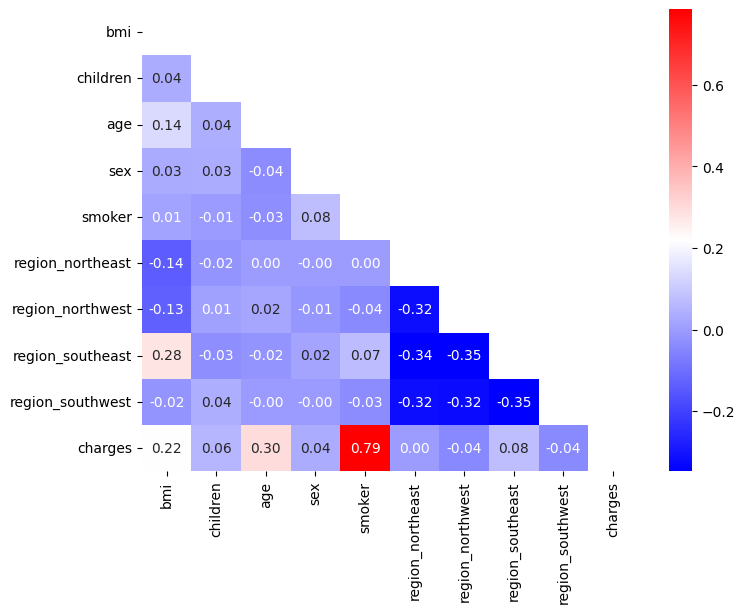

In [56]:
corr_train_pearson = data_train.corr(method='pearson')
viz_heatmap(corr_train_pearson)

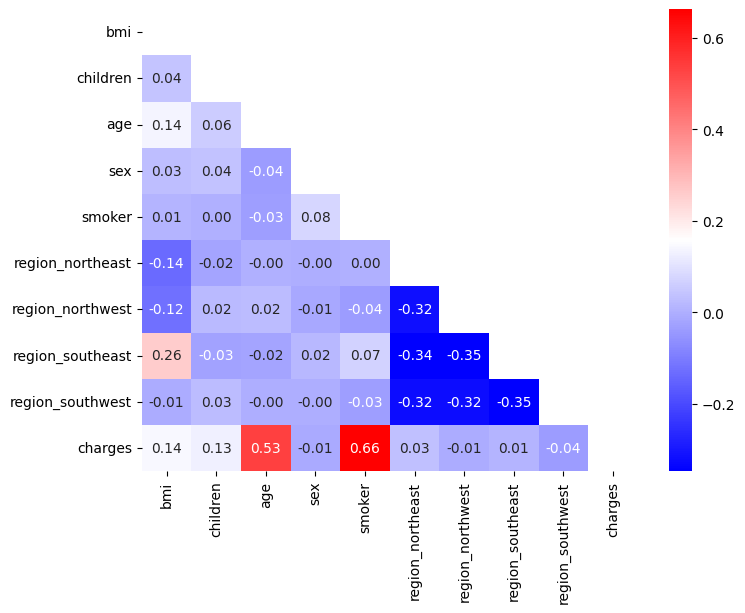

In [57]:
corr_train_spearman = data_train.corr(method='spearman')
viz_heatmap(corr_train_spearman)

In [58]:
X_train_new.shape

(1069, 9)

In [59]:
model_linreg_1= LinearRegression()

#Train our data using linear regression
model_linreg_1.fit(X_train_new, y_train)

LinearRegression()

In [60]:
X_train_new

,bmi,children,age,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,0.296013,0.6,0.152174,1.0,0.0,0.0,0.0,0.0,1.0
1,0.377936,0.0,0.021739,0.0,0.0,0.0,0.0,0.0,1.0
2,0.444293,0.2,0.152174,0.0,0.0,0.0,0.0,1.0,0.0
3,0.539596,0.4,0.543478,0.0,0.0,1.0,0.0,0.0,0.0
4,0.378209,0.4,0.565217,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
1064,0.528127,0.6,0.478261,1.0,0.0,0.0,0.0,0.0,1.0
1065,0.249044,0.0,0.934783,0.0,0.0,0.0,0.0,1.0,0.0
1066,0.601857,0.6,0.347826,0.0,0.0,0.0,0.0,0.0,1.0
1067,0.259421,0.0,0.260870,1.0,0.0,1.0,0.0,0.0,0.0


In [61]:
class ModelEvaluator:
    def __init__(self, train_actual=None, train_predicted=None, test_actual=None, test_predicted=None):
        # Initialize the ModelEvaluator with actual and predicted values for both training and testing datasets
        self.train_actual = train_actual
        self.train_predicted = train_predicted
        self.test_actual = test_actual
        self.test_predicted = test_predicted

    def calculate_metrics(self, y_true, y_pred):
        # Calculate various evaluation metrics for a given set of true and predicted values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R-squared': r2.round(2)
        }

        return metrics 

    def evaluate(self):
        metrics = {}

        if self.train_actual is not None and self.train_predicted is not None:
            # Calculate and store evaluation metrics for the training dataset
            train_metrics = self.calculate_metrics(self.train_actual, self.train_predicted)
            metrics['Train'] = train_metrics

        if self.test_actual is not None and self.test_predicted is not None:
            # Calculate and store evaluation metrics for the testing dataset
            test_metrics = self.calculate_metrics(self.test_actual, self.test_predicted)
            metrics['Test'] = test_metrics

        # Return the evaluation metrics in a DataFrame
        return pd.DataFrame(metrics)

In [62]:
y_train_pred= model_linreg_1.predict(X_train_new)
y_test_pred= model_linreg_1.predict(X_test_new)

In [63]:
evaluator_test = ModelEvaluator(test_actual=y_test, test_predicted=y_test_pred)
evaluator_test.evaluate()

,Test
MAE,4114.434929
MAPE,0.448891
R-squared,0.750000
RMSE,6047.074219


In [64]:
evaluator_both = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both.evaluate().round(3)

,Train,Test
MAE,4195.636,4114.435
RMSE,6065.204,6047.074
MAPE,0.409,0.449
R-squared,0.750,0.750


In [65]:
top_5_corr= corr_train_spearman.charges.abs().nlargest(5) 
top_5_corr= top_5_corr[top_5_corr < 1]
print(top_5_corr)

selected_features= X_train_new[top_5_corr.index].columns
selected_features

smoker      0.662776
age         0.534120
bmi         0.141913
children    0.127283
Name: charges, dtype: float64


Index(['smoker', 'age', 'bmi', 'children'], dtype='object')

In [66]:
model_linreg_2= LinearRegression()

#Train our data using linear regression
model_linreg_2.fit(X_train_new[selected_features], y_train)

y_train_pred= model_linreg_2.predict(X_train_new[selected_features])
y_test_pred= model_linreg_2.predict(X_test_new[selected_features])

In [67]:
evaluator_both_top5 = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both_top5.evaluate().round(3)

,Train,Test
MAE,4225.131,4068.610
RMSE,6065.863,6030.891
MAPE,0.423,0.446
R-squared,0.750,0.750


In [68]:
model_rf_1= RandomForestRegressor(random_state=42)

model_rf_1.fit(X_train_new, y_train)

y_train_pred= model_rf_1.predict(X_train_new)
y_test_pred= model_rf_1.predict(X_test_new)

In [69]:
evaluator_both = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both.evaluate().round(3)

,Train,Test
MAE,1046.983,2526.281
RMSE,1911.648,4767.040
MAPE,0.119,0.309
R-squared,0.980,0.840


In [70]:
model_rf_2= RandomForestRegressor(random_state=42)

model_rf_2.fit(X_train_new[selected_features], y_train)

y_train_pred= model_rf_2.predict(X_train_new[selected_features])
y_test_pred= model_rf_2.predict(X_test_new[selected_features])

In [71]:
evaluator_both_top5 = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both_top5.evaluate().round(3)

,Train,Test
MAE,1065.048,2459.516
RMSE,1972.320,4901.548
MAPE,0.127,0.293
R-squared,0.970,0.830


In [72]:
# Calculating feature importance using permutation method
result = permutation_importance(model_rf_1, X_test_new, y_test,
                                n_repeats=20, random_state=42, scoring='r2')

# Organizing feature importance into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train_new.columns,
                                      'Importance': result.importances_mean,
                                      '+/- std': result.importances_std})

# Sorting feature importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Displaying the feature importance results
print(feature_importance_df.round(3))

            Feature  Importance  +/- std
4            smoker       1.432    0.127
0               bmi       0.304    0.039
2               age       0.199    0.017
1          children       0.018    0.006
6  region_northwest       0.006    0.003
5  region_northeast       0.004    0.002
8  region_southwest      -0.001    0.001
7  region_southeast      -0.002    0.002
3               sex      -0.003    0.003


In [73]:
selected_pfi= feature_importance_df.query("Importance>0")['Feature'].values
selected_pfi

array(['smoker', 'bmi', 'age', 'children', 'region_northwest',
       'region_northeast'], dtype=object)

In [74]:
model_rf_2= RandomForestRegressor(random_state=42)

model_rf_2.fit(X_train_new[selected_pfi], y_train)

y_train_pred= model_rf_2.predict(X_train_new[selected_pfi])
y_test_pred= model_rf_2.predict(X_test_new[selected_pfi])

In [75]:
evaluator_both_pfi = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both_pfi.evaluate().round(3)

,Train,Test
MAE,1050.896,2382.440
RMSE,1949.321,4654.202
MAPE,0.121,0.288
R-squared,0.970,0.850


In [76]:
# Define the RandomForestRegressor model
model_rf_3 = RandomForestRegressor(random_state=42)

# Specify the parameter grid to explore
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'n_estimators': [150,170,190],
    'max_depth': [5,7,10],
    'max_features': [1.0,'sqrt', 'log2']
}

# Initialize HalvingGridSearchCV
halving_gridsearch = HalvingGridSearchCV(estimator=model_rf_3,
                                  param_grid=param_grid, 
                                  factor=2, cv=5, random_state=42,
                                  n_jobs=-1, scoring='neg_mean_absolute_percentage_error'
                                 )

# Train the model with hyperparameter search
halving_gridsearch.fit(X_train_new[selected_pfi], y_train)

print("Best Parameters:", halving_gridsearch.best_params_)
print("Best Validation Score:", halving_gridsearch.best_score_)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 1.0, 'n_estimators': 190}
Best Validation Score: -0.14374402441435669


In [77]:
print(halving_gridsearch.best_estimator_)
print(halving_gridsearch.best_params_)
print(halving_gridsearch.best_index_)

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=190,
                      random_state=42)
{'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 1.0, 'n_estimators': 190}
107


In [78]:
# Create a DataFrame to store the hyperparameter tuning results
hyperparam_rf = pd.DataFrame(halving_gridsearch.cv_results_)

# Sort the results by mean test score in descending order and select specific columns
hyperparam_rf.sort_values('mean_test_score', ascending=False)[
    ['params', 'mean_test_score', 'mean_train_score', 
     'std_test_score', 'std_train_score', 'rank_test_score']].head()

,params,mean_test_score,mean_train_score,std_test_score,std_train_score,rank_test_score
107,"{'criterion': 'absolute_error', 'max_depth': 5...",-0.143744,-0.126279,0.013483,0.002275,1
106,"{'criterion': 'absolute_error', 'max_depth': 5...",-0.144068,-0.126476,0.013298,0.002315,2
105,"{'criterion': 'absolute_error', 'max_depth': 5...",-0.190518,-0.136992,0.023779,0.008514,3
104,"{'criterion': 'absolute_error', 'max_depth': 5...",-0.192602,-0.137591,0.024931,0.008704,4
103,"{'criterion': 'absolute_error', 'max_depth': 5...",-0.193707,-0.138209,0.025070,0.008562,5


In [79]:
print('Total iterations:', hyperparam_rf.shape[0])

Total iterations: 108


In [80]:
best_estimator_rf = halving_gridsearch.best_estimator_ 
best_estimator_rf.fit(X_train_new[selected_pfi], y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=190,
                      random_state=42)

In [81]:
y_train_pred= best_estimator_rf.predict(X_train_new[selected_pfi])
y_test_pred= best_estimator_rf.predict(X_test_new[selected_pfi])

In [82]:
evaluator_best_model = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_best_model.evaluate().round(3)

,Train,Test
MAE,1726.338,1675.159
RMSE,4388.518,4470.775
MAPE,0.126,0.128
R-squared,0.870,0.860


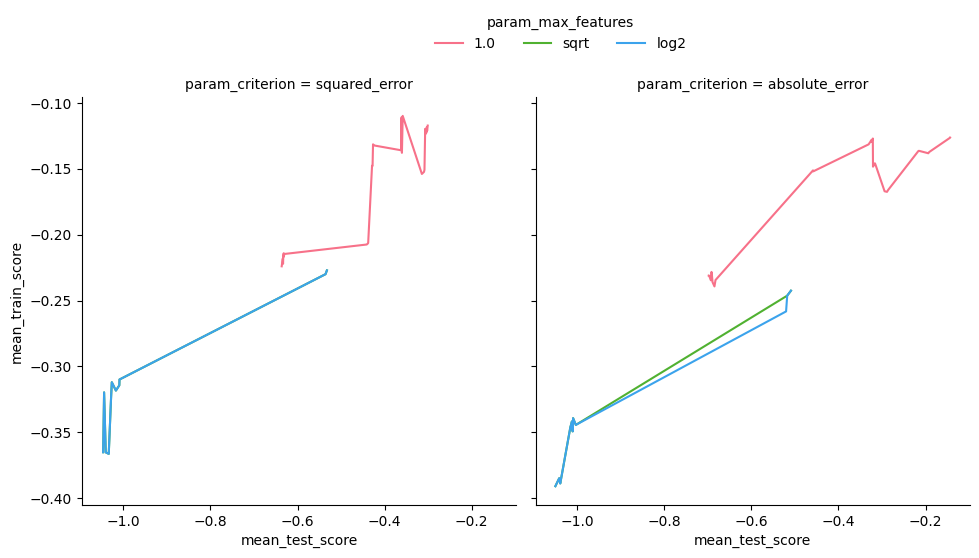

In [83]:
ax=sns.relplot(data=hyperparam_rf,
               kind="line",palette='husl',
               x='mean_test_score',
               y='mean_train_score',
               hue='param_max_features',
               col='param_criterion')

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3)

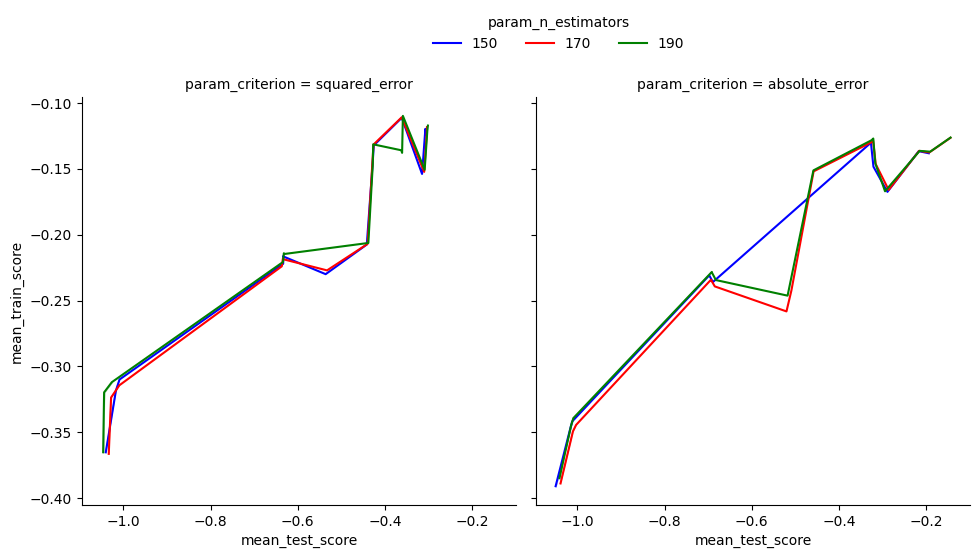

In [84]:
ax=sns.relplot(data=hyperparam_rf,
               kind="line",palette=['blue','red','green'],
               x='mean_test_score',
               y='mean_train_score',
               hue='param_n_estimators',
               col='param_criterion')

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3)

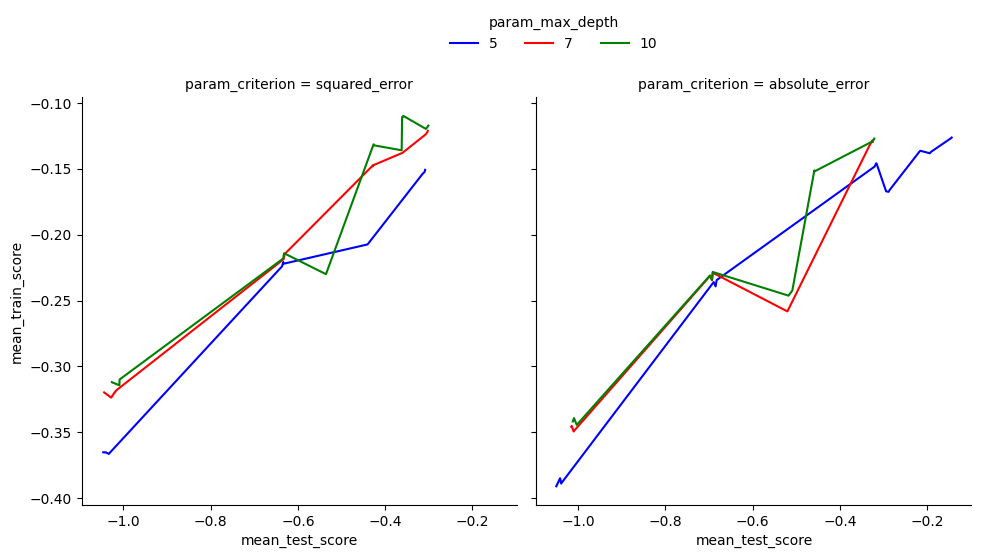

In [85]:
ax=sns.relplot(data=hyperparam_rf,
               kind="line",palette=['blue','red','green'],
               x='mean_test_score',
               y='mean_train_score',
               hue='param_max_depth',
               col='param_criterion')

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3)